# Recommender System - MovieLens
---

This project involves building a predictive model for movie ratings using the MovieLens 1M dataset, which contains 1 million movie ratings along with additional user and movie information. The dataset can be downloaded from the GroupLens website.

The task begins with splitting the dataset into an 80% training set and a 20% test set. Afterward, a predictive model is proposed and implemented to solve the problem of predicting movie ratings. The Mean Squared Error (MSE) on the test set will be used to evaluate the performance of the model and the results will be fully analysed. An explanation of the model implementation, rationale for its selection and test results will be presented in the report.

In the code part of the project, I only used some preprocessing functions from common libraries such as numpy, scipy, pandas, pytorch and sklearn. **I implemented the models myself, without relying on any pre-written packages, to demonstrate my understanding of the algorithms used in these recommender systems.**

Libraries used

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

Load the data and split the ratings matrix into a training and test set.

In [40]:
rating_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movie_names  = ['MovieID', 'Title', 'Genres']
user_names   = ['UserID','Gender','Age','Occupation','Zip-code']
ratings      = pd.read_csv("ratings.dat", delimiter="::", names=rating_names, engine="python", encoding='latin-1')
movies       = pd.read_csv("movies.dat", delimiter="::", names=movie_names, engine="python", encoding='latin-1')
users        = pd.read_csv("users.dat", delimiter="::", names=user_names, engine="python", encoding='latin-1')
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=0)

Inspect the data using the head() function.

In [9]:
train_ratings.head()

,UserID,MovieID,Rating,Timestamp
33203,224,1060,4,976831865
31164,210,653,1,977100156
129530,839,3328,4,975362865
63696,425,813,5,976284767
106422,699,1095,3,975562130


In [10]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Data Visualization

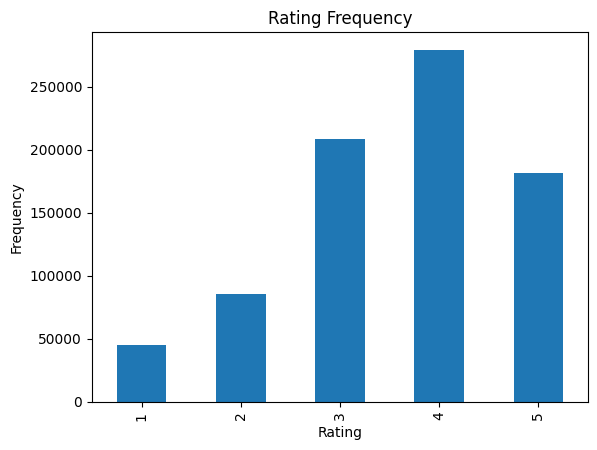

In [34]:
# Bar plot of rating frequency
import matplotlib.pyplot as plt
train_ratings['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Frequency')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

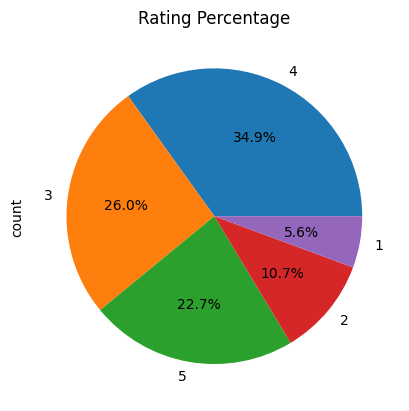

In [35]:
# Pie chart with percentage of each rating
train_ratings['Rating'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Rating Percentage')
plt.show()

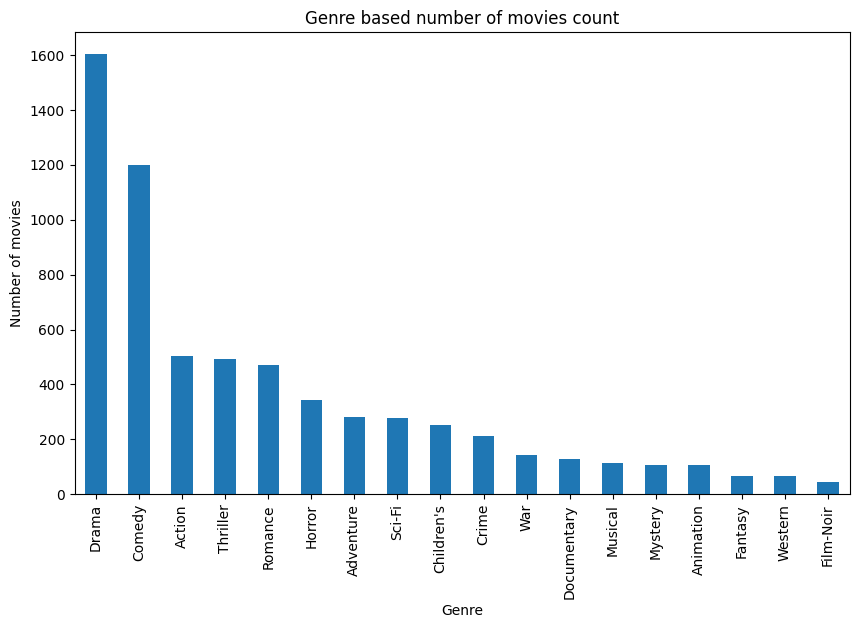

In [36]:
# Bar plot of genre based number of movies count
df = movies.copy()
df['Genres'] = df['Genres'].str.split('|')
df = df.explode('Genres')
genre_counts = df['Genres'].value_counts()

plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar')
plt.title('Genre based number of movies count')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.show()

## 1.	Content-Based

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# Converting movie genres to TF-IDF features
tfidf = TfidfVectorizer()
movie_genres_list = movie_genres.apply(lambda x: ' '.join(x)).tolist()
movie_genres_matrix = tfidf.fit_transform(movie_genres_list)

# Converting movie titles to TF-IDF features
tfidf = TfidfVectorizer()
movie_titles = tfidf.fit_transform(movies['Title'])

movie_content = scipy.sparse.hstack([movie_titles, movie_genres_matrix])

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the film content similarity matrix
movie_content_sim = cosine_similarity(movie_content)

In [25]:
class ContentBasedFiltering:
    def __init__(self, sim_matrix):
        self.sim_matrix = sim_matrix

    def fit(self, ratings):
        self.ratings = ratings

    def predict(self, user, item):
        user_ratings = self.ratings[self.ratings['UserID'] == user]
        watched_movies = user_ratings['MovieID'].values

        if item >= self.sim_matrix.shape[1]:
            return user_ratings['Rating'].mean()

        # Filter out movie IDs that don't exist in sim_matrix
        valid_movies = []
        for movie in watched_movies:
            if movie in self.sim_matrix[:, item]:
                valid_movies.append(movie)

        sim_scores = self.sim_matrix[item, valid_movies]
        sim_scores = sim_scores[sim_scores > 0]

        if len(sim_scores) == 0:
            return self.ratings['Rating'].mean()

        user_ratings = user_ratings[user_ratings['MovieID'].isin(valid_movies)]
        weighted_ratings = np.dot(sim_scores, user_ratings['Rating']) / sim_scores.sum()

        return weighted_ratings

# Fit model
model = ContentBasedFiltering(movie_content_sim)
model.fit(train_ratings)

# Test on testset
predictions = [model.predict(user, item) for user, item in zip(test_ratings['UserID'], test_ratings['MovieID'])]
rmse = np.sqrt(np.mean((test_ratings['Rating'] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  1.127676712728088


## 2.	Collaborative Filtering

In [42]:
# Convert data
train_ratings = train_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).values
test_ratings = test_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).values

#### User Based with Cosine Similarity

In [46]:
def cos_sim(vec1, vec2):
    vec1 = (vec2 + 1e-5) / (vec2 + 1e-5) * vec1
    vec2 = (vec1 + 1e-5) / (vec1 + 1e-5) * vec2
    num = np.sum(vec1 * vec2)
    den = np.sqrt(np.sum(vec1 ** 2)) * np.sqrt(np.sum(vec2 ** 2))
    return num / den

class UserBasedCF:
    def __init__(self, k=20):
        self.k = k

    def fit(self, trainset):
        self.trainset = trainset
        self.n_users, self.n_items = trainset.shape
        self.user_similarity = np.zeros((self.n_users, self.n_users))
        for i in range(self.n_users):
            for j in range(i + 1, self.n_users):
                self.user_similarity[i, j] = self.user_similarity[j, i] = cos_sim(trainset[i], trainset[j])

    def predict(self, user, item):
        user_similarities = self.user_similarity[user]
        top_k_users = np.argsort(-user_similarities)[:self.k]
        item_ratings = self.trainset[top_k_users, item]
        item_ratings = item_ratings[~np.isnan(item_ratings)]
        if len(item_ratings) == 0:
            return self.trainset[:, item].mean()
        user_similarities = user_similarities[top_k_users]
        user_similarities = user_similarities[~np.isnan(item_ratings)]
        return np.sum(item_ratings * user_similarities) / np.sum(user_similarities)

# Fit model
model = UserBasedCF(k=20)
model.fit(train_ratings)

# Test on testset
predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  3.494451056783176


#### User Based with Pearson Similarity

In [47]:
def pear_sim(vec1, vec2):
    c_vec1 = vec1 - np.mean(vec1)
    c_vec2 = vec2 - np.mean(vec2)
    c_vec1 = (c_vec2 + 1e-5) / (c_vec2 + 1e-5) * c_vec1
    c_vec2 = (c_vec1 + 1e-5) / (c_vec1 + 1e-5) * c_vec2
    num = np.sum(c_vec1 * c_vec2)
    den = (np.sum(c_vec1 ** 2)) ** 0.5 * (np.sum(c_vec2 ** 2)) ** 0.5
    return num / den

class UserBasedCF:
    def __init__(self, k=20):
        self.k = k

    def fit(self, trainset):
        self.trainset = trainset
        self.n_users, self.n_items = trainset.shape
        self.user_similarity = np.zeros((self.n_users, self.n_users))
        for i in range(self.n_users):
            for j in range(i + 1, self.n_users):
                self.user_similarity[i, j] = self.user_similarity[j, i] = pear_sim(trainset[i], trainset[j])

    def predict(self, user, item):
        user_similarities = self.user_similarity[user]
        top_k_users = np.argsort(-user_similarities)[:self.k]
        item_ratings = self.trainset[top_k_users, item]
        item_ratings = item_ratings[~np.isnan(item_ratings)]
        if len(item_ratings) == 0:
            return self.trainset[:, item].mean()
        user_similarities = user_similarities[top_k_users]
        user_similarities = user_similarities[~np.isnan(item_ratings)]
        return np.sum(item_ratings * user_similarities) / np.sum(user_similarities)

# Fit model
model = UserBasedCF(k=20)
model.fit(train_ratings)

# Test on testset
predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  3.5479099644304


#### Item Based with Cosine Similarity

In [49]:
def cos_sim(vec1, vec2):
    vec1 = (vec2 + 1e-5) / (vec2 + 1e-5) * vec1
    vec2 = (vec1 + 1e-5) / (vec1 + 1e-5) * vec2
    num = np.sum(vec1 * vec2)
    den = np.sqrt(np.sum(vec1 ** 2)) * np.sqrt(np.sum(vec2 ** 2))
    return num / den

class ItemBasedCF:
    def __init__(self, k=20):
        self.k = k

    def fit(self, trainset):
        self.trainset = trainset.T
        self.n_items, self.n_users = self.trainset.shape
        self.item_similarity = np.zeros((self.n_items, self.n_items))
        for i in range(self.n_items):
            for j in range(i + 1, self.n_items):
                self.item_similarity[i, j] = self.item_similarity[j, i] = cos_sim(self.trainset[i], self.trainset[j])

    def predict(self, user, item):
        item_similarities = self.item_similarity[item]
        top_k_items = np.argsort(-item_similarities)[:self.k]
        user_ratings = self.trainset[:, user]
        user_ratings = user_ratings[top_k_items]
        user_ratings = user_ratings[~np.isnan(user_ratings)]
        if len(user_ratings) == 0:
            return self.trainset[:, user].mean()
        item_similarities = item_similarities[top_k_items]
        item_similarities = item_similarities[~np.isnan(user_ratings)]
        return np.sum(user_ratings * item_similarities) / np.sum(item_similarities)

# Fit model
model = ItemBasedCF(k=20)
model.fit(train_ratings)

# Test on testset
predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  3.4646989334391756


#### Item Based with Pearson Similarity

In [43]:
def pear_sim(vec1, vec2):
    c_vec1 = vec1 - np.mean(vec1)
    c_vec2 = vec2 - np.mean(vec2)
    c_vec1 = (c_vec2 + 1e-5) / (c_vec2 + 1e-5) * c_vec1
    c_vec2 = (c_vec1 + 1e-5) / (c_vec1 + 1e-5) * c_vec2
    num = np.sum(c_vec1 * c_vec2)
    den = (np.sum(c_vec1 ** 2)) ** 0.5 * (np.sum(c_vec2 ** 2)) ** 0.5
    return num / den

class ItemBasedCF:
    def __init__(self, k=20):
        self.k = k

    def fit(self, trainset):
        self.trainset = trainset.T
        self.n_items, self.n_users = self.trainset.shape
        self.item_similarity = np.zeros((self.n_items, self.n_items))
        for i in range(self.n_items):
            for j in range(i + 1, self.n_items):
                self.item_similarity[i, j] = self.item_similarity[j, i] = pear_sim(self.trainset[i], self.trainset[j])

    def predict(self, user, item):
        item_similarities = self.item_similarity[item]
        top_k_items = np.argsort(-item_similarities)[:self.k]
        user_ratings = self.trainset[:, user]
        user_ratings = user_ratings[top_k_items]
        user_ratings = user_ratings[~np.isnan(user_ratings)]
        if len(user_ratings) == 0:
            return self.trainset[:, user].mean()
        item_similarities = item_similarities[top_k_items]
        item_similarities = item_similarities[~np.isnan(user_ratings)]
        return np.sum(user_ratings * item_similarities) / np.sum(item_similarities)

# Fit model
model = ItemBasedCF(k=20)
model.fit(train_ratings)

# Test on testset
predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  3.5296624277273656


## 3.	SVD
Regularisation is introduced to prevent overfitting

In [44]:
from sklearn.utils import shuffle

class SVD:
    def __init__(self, n_factors=100, n_epochs=20, lr=0.01, reg=0.02):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg

    def fit(self, ratings):
        self.n_users, self.n_items = ratings.shape
        self.user_factors = np.random.rand(self.n_users, self.n_factors)
        self.item_factors = np.random.rand(self.n_items, self.n_factors)

        for epoch in range(self.n_epochs):
            ratings = shuffle(ratings)
            for user, item in zip(*ratings.nonzero()):
                rating = ratings[user, item]
                err = rating - np.dot(self.user_factors[user], self.item_factors[item])
                self.user_factors[user] += self.lr * (err * self.item_factors[item] - self.reg * self.user_factors[user])
                self.item_factors[item] += self.lr * (err * self.user_factors[user] - self.reg * self.item_factors[item])

    def predict(self, user, item):
        return np.dot(self.user_factors[user], self.item_factors[item])

# Fit model
model = SVD(n_factors=40, n_epochs=40, lr=0.005, reg=0.05)
model.fit(train_ratings)

# Test on testset
predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
print("RMSE: ", rmse)

RMSE:  1.3213269988150962


#### Tuning hyperparameters

In [35]:
# Define the range of hyperparameters
param_grid = {'n_factors': [40, 60, 80, 100],
              'n_epochs': [20, 40, 60, 80],
              'lr': [0.001, 0.005, 0.01, 0.05],
              'reg': [0.01, 0.02, 0.05, 0.1]}

best_rmse = np.inf
best_params = None

# Grid Search
for n_factors in param_grid['n_factors']:
    for n_epochs in param_grid['n_epochs']:
        for lr in param_grid['lr']:
            for reg in param_grid['reg']:
                model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr=lr, reg=reg)
                model.fit(train_ratings)
                predictions = np.array([model.predict(user, item) for user, item in zip(*test_ratings.nonzero())])
                rmse = np.sqrt(np.mean((test_ratings[test_ratings.nonzero()] - predictions) ** 2))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr': lr, 'reg': reg}
                print(f"n_factors={n_factors}, n_epochs={n_epochs}, lr={lr}, reg={reg}, RMSE={rmse}")

print(f"Best params: {best_params}, Best RMSE: {best_rmse}")

n_factors=40, n_epochs=20, lr=0.001, reg=0.01, RMSE=1.5985428724407695
n_factors=40, n_epochs=20, lr=0.001, reg=0.02, RMSE=1.5868573841038907
n_factors=40, n_epochs=20, lr=0.001, reg=0.05, RMSE=1.5350327863470499
n_factors=40, n_epochs=20, lr=0.001, reg=0.1, RMSE=1.5027671823544866
n_factors=40, n_epochs=20, lr=0.005, reg=0.01, RMSE=1.3681479402835797
n_factors=40, n_epochs=20, lr=0.005, reg=0.02, RMSE=1.3552866612006929
n_factors=40, n_epochs=20, lr=0.005, reg=0.05, RMSE=1.3374229781732705
n_factors=40, n_epochs=20, lr=0.005, reg=0.1, RMSE=1.3265145220901426
n_factors=40, n_epochs=20, lr=0.01, reg=0.01, RMSE=1.336217745879761
n_factors=40, n_epochs=20, lr=0.01, reg=0.02, RMSE=1.334154651476527
n_factors=40, n_epochs=20, lr=0.01, reg=0.05, RMSE=1.3240120871673466
n_factors=40, n_epochs=20, lr=0.01, reg=0.1, RMSE=1.3291196261791127


<ipython-input-34-a636f87fc361>:23: RuntimeWarning: overflow encountered in multiply
  self.item_factors[item] += self.lr * (err * self.user_factors[user] - self.reg * self.item_factors[item])
<ipython-input-34-a636f87fc361>:22: RuntimeWarning: overflow encountered in multiply
  self.user_factors[user] += self.lr * (err * self.item_factors[item] - self.reg * self.user_factors[user])
<ipython-input-34-a636f87fc361>:22: RuntimeWarning: invalid value encountered in add
  self.user_factors[user] += self.lr * (err * self.item_factors[item] - self.reg * self.user_factors[user])


n_factors=40, n_epochs=20, lr=0.05, reg=0.01, RMSE=nan
n_factors=40, n_epochs=20, lr=0.05, reg=0.02, RMSE=nan
n_factors=40, n_epochs=20, lr=0.05, reg=0.05, RMSE=nan
n_factors=40, n_epochs=20, lr=0.05, reg=0.1, RMSE=nan
n_factors=40, n_epochs=40, lr=0.001, reg=0.01, RMSE=1.4603654300778013
n_factors=40, n_epochs=40, lr=0.001, reg=0.02, RMSE=1.4522310613792522
n_factors=40, n_epochs=40, lr=0.001, reg=0.05, RMSE=1.4070256627283977
n_factors=40, n_epochs=40, lr=0.001, reg=0.1, RMSE=1.3779472765011338
n_factors=40, n_epochs=40, lr=0.005, reg=0.01, RMSE=1.3279387850386781
n_factors=40, n_epochs=40, lr=0.005, reg=0.02, RMSE=1.3181298794298786
n_factors=40, n_epochs=40, lr=0.005, reg=0.05, RMSE=1.3091306967927565
n_factors=40, n_epochs=40, lr=0.005, reg=0.1, RMSE=1.3096998544203058
n_factors=40, n_epochs=40, lr=0.01, reg=0.01, RMSE=1.3279593122547522
n_factors=40, n_epochs=40, lr=0.01, reg=0.02, RMSE=1.33078771321694
n_factors=40, n_epochs=40, lr=0.01, reg=0.05, RMSE=1.3259091639691403
n_facto

<ipython-input-34-a636f87fc361>:23: RuntimeWarning: invalid value encountered in subtract
  self.item_factors[item] += self.lr * (err * self.user_factors[user] - self.reg * self.item_factors[item])


n_factors=40, n_epochs=40, lr=0.05, reg=0.01, RMSE=nan
n_factors=40, n_epochs=40, lr=0.05, reg=0.02, RMSE=nan
n_factors=40, n_epochs=40, lr=0.05, reg=0.05, RMSE=nan
n_factors=40, n_epochs=40, lr=0.05, reg=0.1, RMSE=nan
n_factors=40, n_epochs=60, lr=0.001, reg=0.01, RMSE=1.3973171568519147
n_factors=40, n_epochs=60, lr=0.001, reg=0.02, RMSE=1.3798856660888699
n_factors=40, n_epochs=60, lr=0.001, reg=0.05, RMSE=1.3595638049892536
n_factors=40, n_epochs=60, lr=0.001, reg=0.1, RMSE=1.3435099026777466
n_factors=40, n_epochs=60, lr=0.005, reg=0.01, RMSE=1.3191951698998778
n_factors=40, n_epochs=60, lr=0.005, reg=0.02, RMSE=1.3159074576337453
n_factors=40, n_epochs=60, lr=0.005, reg=0.05, RMSE=1.320074802821274
n_factors=40, n_epochs=60, lr=0.005, reg=0.1, RMSE=1.3198646443669269
n_factors=40, n_epochs=60, lr=0.01, reg=0.01, RMSE=1.3407923918205953
n_factors=40, n_epochs=60, lr=0.01, reg=0.02, RMSE=1.3342741638942095
n_factors=40, n_epochs=60, lr=0.01, reg=0.05, RMSE=1.3282820132764233
n_fact

KeyboardInterrupt: 

Because the grid search was so time-consuming, I picked the parameters corresponding to the optimal model before terminating the procedure

## 4.	Softmax Deep Neural Networks

In [32]:
import numpy as np
import pandas as pd
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

# Data processing
users = ratings['UserID'].unique()
movies = ratings['MovieID'].unique()

num_users = len(users)
num_movies = len(movies)

user_ids_train = np.array([users.tolist().index(user) for user in train_ratings['UserID']])
movie_ids_train = np.array([movies.tolist().index(movie) for movie in train_ratings['MovieID']])
ratings_train = train_ratings['Rating'].values - 1  # Map scores to a range of 0-8

user_ids_test = np.array([users.tolist().index(user) for user in test_ratings['UserID']])
movie_ids_test = np.array([movies.tolist().index(movie) for movie in test_ratings['MovieID']])
ratings_test = test_ratings['Rating'].values - 1

# Build Softmax deep neural network
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

user_embed = Embedding(num_users, 50, input_length=1)(user_input)
movie_embed = Embedding(num_movies, 50, input_length=1)(movie_input)

x = Flatten()(tf.concat([user_embed, movie_embed], axis=-1))
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

model = Model(inputs=[user_input, movie_input], outputs=output)

# Compilation
optimizer = SGD()
loss = SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss)

# Print time
start_time = time.time()
model.fit([user_ids_train, movie_ids_train], ratings_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Test on testset
predictions = model.predict([user_ids_test, movie_ids_test])
predictions = np.argmax(predictions, axis=1) + 1
rmse = np.sqrt(np.mean((predictions - ratings_test - 1) ** 2))
print("RMSE: ", rmse)

Training time: 328.48 seconds
6252/6252 [==============================] - 8s 1ms/step
RMSE:  1.0151446158532635
